Task 2 - Predictive Modelling of Delays

In Task 1, we showed that train delays are not random but depend on spatial, temporal, and operational conditions.
In Task 2, we move to the Modelling & Evaluation stage of the AI lifecycle and use these insights to predict how delays evolve along a train’s route.

Our goal is not only to predict future delays, but also to understand when delays propagate and when they recover.

Predictive Target

The prediction target is the difference in delay between the current station and the next station.
This directly captures whether a delay increases (propagation) or decreases (recovery) from one stop to the next.

The target is operationally meaningful for dispatching and passenger information, and causally valid because it uses only information available at the current station.

Hypotheses

We test the following hypotheses:

H3: The current operational state and temporal context explain a substantial share of Δd (delay propagation vs. recovery).

H4: Non-linear models outperform linear baselines because Δd depends on interactions (e.g. train type × time-of-day) and exhibits heavy-tailed behaviour

The railway system is a temporally evolving process.
Even if different trains appear in the dataset, the operational environment (weather, demand, disruptions, infrastructure) changes over time.

A random train/test split would therefore introduce temporal information leakage, because the model would be trained on future system states relative to the test samples.
To compare model classes across different seasonal regimes, we first evaluate how well each model generalizes to an unseen calendar month.
This does not simulate real-time forecasting. Instead, it answers:

“If a full monthly regime were unseen, could the model generalize to it?”

This is particularly relevant for our dataset, which intentionally spans summer and winter periods.

We therefore use a leave-one-month-out blocked cross-validation scheme.


We will winsorize Δdelay at the 1st and 99th percentiles (±40 min).
This preserves 98% of the data while stabilizing estimation.

Apply target clipping

We cap extreme delay changes to reduce the influence of rare outliers.


In [2]:
import pandas as pd
import numpy as np
import holidays

df_panel = pd.read_parquet("data/processed/df_panel.parquet")
df_day   = pd.read_parquet("data/processed/daily_station_weather.parquet")
df_map   = pd.read_parquet("data/processed/station_geo.parquet")


2) Calendar + merges

We derive calendar features and merge exogenous weather and static geo data.

In [6]:
df_evt = df_panel.copy()
df_evt["time"] = pd.to_datetime(df_evt["time"])

de_holidays = holidays.Germany(years=df_evt["time"].dt.year.unique().tolist())
df_evt["date"] = df_evt["time"].dt.date
df_evt["hour"] = df_evt["time"].dt.hour
df_evt["dow"]  = df_evt["time"].dt.weekday

df_evt["is_weekend"] = df_evt["dow"].isin([5,6]).astype(int)
df_evt["is_holiday"] = df_evt["date"].isin(de_holidays).astype(int)
df_evt["is_workday"] = ((df_evt["is_weekend"]==0)&(df_evt["is_holiday"]==0)).astype(int)
df_evt["is_peak"] = (df_evt["hour"].between(6,9)|df_evt["hour"].between(16,19)).astype(int)
df_evt["is_night"] = df_evt["hour"].between(0,5).astype(int)

df_evt["month"] = df_evt["time"].dt.to_period("M")

df_day["date"] = pd.to_datetime(df_day["date"]).dt.date
df_evt["eva"] = df_evt["eva"].astype(str)
df_day["eva"] = df_day["eva"].astype(str)

df_evt = df_evt.merge(df_day[["eva","date","tavg","prcp","snow"]], on=["eva","date"], how="left")
df_evt = df_evt.merge(df_map[["station_name","lat","lon"]].drop_duplicates("station_name"),
                      on="station_name", how="left")


MemoryError: Unable to allocate 535. MiB for an array with shape (6, 11695724) and data type int64

3) Build segment physics + target

We derive operational and physical context features and the raw signed target.

In [5]:
df = df_evt.copy()

df["delay_pos"] = df["delay_in_min"].clip(lower=0)

df["dwell_slack"] = (pd.to_datetime(df["departure_planned_time"]) -
                     pd.to_datetime(df["arrival_planned_time"])).dt.total_seconds()/60
df["actual_dwell"] = (pd.to_datetime(df["departure_change_time"]) -
                      pd.to_datetime(df["arrival_change_time"])).dt.total_seconds()/60

df["arr_planned_dt"] = pd.to_datetime(df["arrival_planned_time"])
df["dep_planned_dt"] = pd.to_datetime(df["departure_planned_time"])

df = df.sort_values(["train_line_ride_id","train_line_station_num","time"])
df["next_arr_planned_dt"] = df.groupby("train_line_ride_id")["arr_planned_dt"].shift(-1)
df["travel_time"] = (df["next_arr_planned_dt"] - df["dep_planned_dt"]).dt.total_seconds()/60
df["travel_time"] = df["travel_time"].where(df["travel_time"].between(0,300))

df["next_lat"] = df.groupby("train_line_ride_id")["lat"].shift(-1)
df["next_lon"] = df.groupby("train_line_ride_id")["lon"].shift(-1)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df["distance_to_next"] = haversine_km(df["lat"], df["lon"], df["next_lat"], df["next_lon"])
df["distance_to_next"] = df["distance_to_next"].where(df["distance_to_next"].between(0,500))

df["current_delay"] = df["delay_in_min"]
df["next_delay"] = df.groupby("train_line_ride_id")["current_delay"].shift(-1)
df["delta_delay"] = df["next_delay"] - df["current_delay"]
df = df.dropna(subset=["delta_delay"])


4) Folds + December split + target clipping to handle outliers

In [6]:
months = sorted(df["month"].unique())
folds = [(m, df[df["month"]!=m].index, df[df["month"]==m].index) for m in months]

diag_month = [m for m,_,_ in folds if str(m).endswith("-12")][0]
train = df[df["month"] != diag_month].copy()
test  = df[df["month"] == diag_month].copy()

low, high = train["delta_delay"].quantile([0.01,0.99])
train["delta_delay_clip"] = train["delta_delay"].clip(low, high)
test["delta_delay_clip"]  = test["delta_delay"].clip(low, high)




Create Fold safe station stats because it cant be in the test set

In [7]:
def add_station_stats_foldsafe(train_df, test_df):
    s = (train_df.assign(delay_pos=lambda x: x["delay_in_min"].clip(lower=0))
         .groupby("station_name")
         .agg(
             station_cancel_rate=("is_canceled","mean"),
             station_mean_delay=("delay_pos","mean"),
             station_p90_delay=("delay_pos",lambda x: x.quantile(0.90)),
             traffic_volume=("id","count"),
         ).reset_index())
    s["station_risk_score"] = s["station_mean_delay"] + 30*s["station_cancel_rate"]
    cols = ["station_name","station_cancel_rate","station_mean_delay",
            "station_p90_delay","traffic_volume","station_risk_score"]
    train_out = train_df.merge(s[cols], on="station_name", how="left", validate="m:1")
    test_out  = test_df.merge(s[cols],  on="station_name", how="left", validate="m:1")
    train_out = train_out.rename(columns={"traffic_volume":"station_volume"})
    test_out  = test_out.rename(columns={"traffic_volume":"station_volume"})
    return train_out, test_out

train, test = add_station_stats_foldsafe(train, test)


Feature construction: Numerical and dummy variables, introduce dummy for summer vs. winter

In [8]:
summer_months = [6, 7, 8]
df["is_summer"] = df["month"].isin(summer_months).astype(int)
train["is_summer"] = train["month"].isin([6,7,8]).astype(int)
test["is_summer"]  = test["month"].isin([6,7,8]).astype(int)



In [37]:
num_vars = [
    "delay_pos","train_line_station_num",
    "tavg","prcp","snow",
    "station_cancel_rate","station_p90_delay","station_risk_score","station_volume",
    "lat","lon","hour","dow",
    "dwell_slack","actual_dwell",
    "distance_to_next","travel_time"
]

dummy_vars = ["is_peak","is_weekend","is_holiday","is_workday","is_night", "is_summer"]
features = num_vars + dummy_vars

y_train = train["delta_delay_clip"]; y_test = test["delta_delay_clip"]
X_train = train[features]; X_test = test[features]


In [38]:
print("Train rows:", len(train))
print("Test rows :", len(test))


Train rows: 9672909
Test rows : 1956978


### Subsampling for Linear Regression Diagnostics

The full training set contains more than 9 million observations, which makes classical OLS regression with diagnostic tests computationally infeasible.  
Since the purpose of the linear model at this stage is **methodological analysis** (multicollinearity, heteroskedasticity, residual structure) rather than final predictive performance, we fit the regression on a representative subsample.

We therefore draw a random subsample of 200,000 training observations:

- large enough for stable coefficient estimates  
- small enough for fast and memory-efficient computation  

All subsequent regression diagnostics are performed on this subsample, while predictive models are later evaluated on the full validation folds.


In [39]:
N = 200_000
train_sub = train.sample(N, random_state=42)

X_train = train_sub[features]
y_train = train_sub["delta_delay_clip"]

X_test  = test[features]
y_test  = test["delta_delay_clip"]


In [40]:
import json, os

os.makedirs("data/processed", exist_ok=True)

# save train subset
train_sub.to_parquet("data/processed/train_sub_task2.parquet", index=False)

# save test set
test.to_parquet("data/processed/test_task2.parquet", index=False)

# save feature list
with open("data/processed/features_task2.json", "w") as f:
    json.dump(features, f)

print("Saved Task 2 data:")
print("Train:", train_sub.shape)
print("Test :", test.shape)


Saved Task 2 data:
Train: (200000, 52)
Test : (1956978, 53)


The training and test sets are saved that they can be resued for the classification in task 3.

Define linear-friendly preprocessing and fit the December diagnostic regression

We apply outlier capping, KNN imputation, and robust scaling to numeric features (fit on train only), then estimate an OLS baseline on training months and evaluate on December

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd

def preprocess_linear_features_fast(X_train, X_test, num_cols, cat_cols, q=0.01):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    # 1) winsorize
    for c in num_cols:
        lo, hi = X_train[c].quantile([q, 1-q])
        X_train[c] = X_train[c].clip(lo, hi)
        X_test[c]  = X_test[c].clip(lo, hi)

    # 2) median impute
    imputer = SimpleImputer(strategy="median")
    X_train_num = pd.DataFrame(imputer.fit_transform(X_train[num_cols]),
                               columns=num_cols, index=X_train.index)
    X_test_num  = pd.DataFrame(imputer.transform(X_test[num_cols]),
                               columns=num_cols, index=X_test.index)

    # 3) robust scale
    scaler = RobustScaler()
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num),
                               columns=num_cols, index=X_train.index)
    X_test_num  = pd.DataFrame(scaler.transform(X_test_num),
                               columns=num_cols, index=X_test.index)

    # 4) concat with dummies
    X_train_proc = pd.concat([X_train_num, X_train[cat_cols].astype(float)], axis=1)
    X_test_proc  = pd.concat([X_test_num,  X_test[cat_cols].astype(float)], axis=1)

    return X_train_proc, X_test_proc


In [13]:
X_train_proc, X_test_proc = preprocess_linear_features_fast(
    X_train, X_test, num_vars, dummy_vars
)


In [14]:
import statsmodels.api as sm

Xc_train = sm.add_constant(X_train_proc)
Xc_test  = sm.add_constant(X_test_proc, has_constant="add")

lin_model = sm.OLS(y_train, Xc_train).fit()
print(lin_model.summary())


                            OLS Regression Results                            
Dep. Variable:       delta_delay_clip   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     7055.
Date:                Sat, 31 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:19:40   Log-Likelihood:            -6.7709e+05
No. Observations:              200000   AIC:                         1.354e+06
Df Residuals:                  199978   BIC:                         1.354e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [15]:
lin_model.params[lin_model.params.index.str.contains("summer", case=False)]


is_summer    0.0
dtype: float64

The explicit seasonal indicator (is_summer) does not contribute additional
explanatory power once weather and temporal features are included. This
suggests that seasonality is already implicitly captured by correlated
covariates such as temperature and time-of-day.


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = lin_model.predict(Xc_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\nDecember diagnostic performance:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.4f}")



December diagnostic performance:
MAE  = 4.075
RMSE = 7.295
R2   = 0.4178


### Baseline Linear Model: Summary and Next Steps

We first fit a baseline linear regression model to predict the change in delay
(`delta_delay_clip`) using operational, temporal, spatial, and weather-related
features. Due to the large data volume (>9 million training observations), all
regression diagnostics were performed on a representative random subsample of
200,000 training rows.

The model achieves a robust out-of-time performance on the December test month:

- **MAE:** 4.08 minutes  
- **RMSE:** 7.30 minutes  
- **R²:** 0.418  

This indicates that a substantial share of delay dynamics can be explained by
structural features available at the time of prediction.

However, regression diagnostics reveal several violations of classical OLS
assumptions:

- **Strong multicollinearity** (very high condition number)
- **Non-normal, heavy-tailed residuals**
- **Heteroskedasticity and complex error structure**

In the following, we therefore:
1. Analyze multicollinearity in more detail and reduce redundant variables,  
2. Introduce interaction terms motivated by exploratory analysis, and  
3. Apply Ridge regression to stabilize the linear model.

This prepares the ground for comparison with non-linear models in the next section.


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# ohne Konstante
X_vif = X_train_proc.copy()

vif = pd.DataFrame()
vif["feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i)
              for i in range(X_vif.shape[1])]

vif = vif.sort_values("VIF", ascending=False)
vif.head(15)


c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
6,station_p90_delay,51.594026
7,station_risk_score,47.182682
5,station_cancel_rate,6.660788
20,is_workday,3.549339
18,is_weekend,2.735782
13,dwell_slack,2.553282
14,actual_dwell,2.543288
12,dow,2.491653
10,lon,2.213293
21,is_night,1.758343


In [18]:
drop_cols = ["station_p90_delay"]
X_train_red = X_train_proc.drop(columns=drop_cols)
X_test_red  = X_test_proc.drop(columns=drop_cols)

Xc_train_red = sm.add_constant(X_train_red)
lin_model_red = sm.OLS(y_train, Xc_train_red).fit()

print(lin_model_red.summary())



                            OLS Regression Results                            
Dep. Variable:       delta_delay_clip   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     7408.
Date:                Sat, 31 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:20:20   Log-Likelihood:            -6.7709e+05
No. Observations:              200000   AIC:                         1.354e+06
Df Residuals:                  199979   BIC:                         1.354e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X_train_red.copy()

vif_new = pd.DataFrame()
vif_new["feature"] = X_vif.columns
vif_new["VIF"] = [variance_inflation_factor(X_vif.values, i)
                  for i in range(X_vif.shape[1])]

vif_new = vif_new.sort_values("VIF", ascending=False)
vif_new.head(15)



c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
19,is_workday,3.333086
17,is_weekend,2.656457
12,dwell_slack,2.553269
13,actual_dwell,2.543213
11,dow,2.491640
20,is_night,1.758270
6,station_risk_score,1.721934
9,lon,1.683484
10,hour,1.629420
5,station_cancel_rate,1.547980


After dropping station_p90_delay all independent variables have a varinace inflation factor of less than 10 so less than 90% is explained by the other independent variables. The R² is unchanged so dropping the high VIF variable did not decrease the model´s performance. In the next step we will test for autocorrelation

In [20]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(lin_model.resid)
print("Durbin-Watson:", round(dw, 3))


Durbin-Watson: 2.007


# Autocorrelation

The Durbin–Watson statistic is 2.01, which is very close to the ideal value of 2.
This indicates that there is no significant autocorrelation in the regression
residuals. Therefore, temporal dependence is not a major concern for the linear
baseline model. In the next step we will see if there is heteroscedasticity in the residuals.


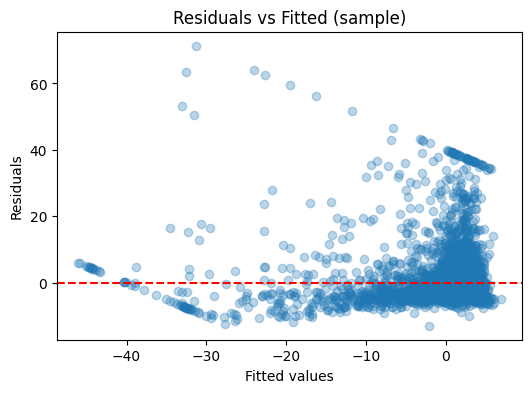

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fitted = lin_model.fittedvalues
resid = lin_model.resid

plt.figure(figsize=(6,4))
plt.scatter(fitted[:5000], resid[:5000], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (sample)")
plt.show()


In [23]:
import statsmodels.stats.api as sms

white = sms.het_white(lin_model.resid, lin_model.model.exog)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]

dict(zip(labels, white))


{'LM stat': np.float64(9652.664013920243),
 'LM p-value': np.float64(0.0),
 'F stat': np.float64(41.17736860970846),
 'F p-value': np.float64(0.0)}

In [24]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp = het_breuschpagan(lin_model.resid, lin_model.model.exog)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]

dict(zip(labels, bp))


{'LM stat': np.float64(6366.794020764232),
 'LM p-value': np.float64(0.0),
 'F stat': np.float64(313.1150117036283),
 'F p-value': np.float64(0.0)}

In [25]:
lin_model_red_robust = lin_model_red.get_robustcov_results(cov_type="HC3")
print(lin_model_red_robust.summary())


                            OLS Regression Results                            
Dep. Variable:       delta_delay_clip   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     5768.
Date:                Sat, 31 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:24:39   Log-Likelihood:            -6.7709e+05
No. Observations:              200000   AIC:                         1.354e+06
Df Residuals:                  199979   BIC:                         1.354e+06
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 21
  warnings.warn('covariance of constraints does not have full '


### Interpretation of the Linear Baseline Model

The reduced OLS model with heteroskedasticity-robust (HC3) standard errors
achieves a robust explanatory power on the training subsample (same to the baseline model), with an
**R² of 0.426** (adjusted R² = 0.426). This indicates that a substantial share
of the short-term delay dynamics can already be explained by structural,
temporal, spatial, and weather-related features.

The model is globally significant (**F-test p < 0.001**), and most operational
and temporal variables are highly significant at the 1% level. In particular,
previous delay (`delay_pos`), position along the route (`train_line_station_num`),
time-of-day (`hour`), station risk (`station_risk_score`), and nighttime
operation (`is_night`) exhibit strong and stable effects.

Several features such as precipitation, snow, and station volume are not
statistically significant in the linear specification. This suggests that
their impact may not be additive, but instead depends on context such as
temperature or time-of-day.

The information criteria (**AIC = 1.354e+06, BIC = 1.354e+06**) provide a useful
baseline for later model comparisons. Residual diagnostics further reveal
heavy-tailed and heteroskedastic errors, indicating remaining non-linear
structure that cannot be captured by a purely additive linear model.

Motivated by the interaction patterns observed in Task 1 (e.g., between
temperature and precipitation), we therefore extend the model with selected
interaction terms in the next step.


In [26]:
X_train_int = X_train_red.copy()
X_test_int  = X_test_red.copy()

X_train_int["temp_x_rain"]  = X_train_int["tavg"] * X_train_int["prcp"]
X_train_int["temp_x_snow"]  = X_train_int["tavg"] * X_train_int["snow"]
X_train_int["rain_x_night"] = X_train_int["prcp"] * X_train_int["is_night"]
X_train_int["snow_x_night"] = X_train_int["snow"] * X_train_int["is_night"]
X_train_int["temp_x_night"] = X_train_int["tavg"] * X_train_int["is_night"]
X_train_int["summer_x_rain"]= X_train_int["is_summer"] * X_train_int["prcp"]

# test
X_test_int["temp_x_rain"]   = X_test_int["tavg"] * X_test_int["prcp"]
X_test_int["temp_x_snow"]   = X_test_int["tavg"] * X_test_int["snow"]
X_test_int["rain_x_night"]  = X_test_int["prcp"] * X_test_int["is_night"]
X_test_int["snow_x_night"]  = X_test_int["snow"] * X_test_int["is_night"]
X_test_int["temp_x_night"]  = X_test_int["tavg"] * X_test_int["is_night"]
X_test_int["summer_x_rain"] = X_test_int["is_summer"] * X_test_int["prcp"]


In [27]:
Xc_train_int = sm.add_constant(X_train_int)
lin_model_int = sm.OLS(y_train, Xc_train_int).fit()
lin_model_int_hc3 = lin_model_int.get_robustcov_results(cov_type="HC3")
print(lin_model_int_hc3.summary())


                            OLS Regression Results                            
Dep. Variable:       delta_delay_clip   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     4662.
Date:                Sat, 31 Jan 2026   Prob (F-statistic):               0.00
Time:                        22:24:53   Log-Likelihood:            -6.7708e+05
No. Observations:              200000   AIC:                         1.354e+06
Df Residuals:                  199974   BIC:                         1.354e+06
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

c:\Users\Joni7\OneDrive\DRL\Stipendien\Applied AI\aai_final_case_study\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 26
  warnings.warn('covariance of constraints does not have full '


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
Xc_test_int = sm.add_constant(X_test_int)
# Vorhersage mit dem Interaktionsmodell
y_pred = lin_model_int.predict(Xc_test_int)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\nDecember performance (interaction model):")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.4f}")



December performance (interaction model):
MAE  = 4.070
RMSE = 7.295
R2   = 0.4178


The R² is the same after adding the interaction terms showing that they hold little predictive power and their effect is already explained by the existing variables. In the next step all p-values of the variables are checked.

In [29]:
import pandas as pd

# p-values aus dem robusten Modell
pvals = pd.Series(lin_model_int_hc3.pvalues, index=lin_model_int_hc3.model.exog_names)

pval_table = (
    pvals.reset_index()
         .rename(columns={"index": "feature", 0: "p_value"})
         .sort_values("p_value")
)

# Signifikanzsterne
def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    if p < 0.1:   return "."
    return ""

pval_table["sig"] = pval_table["p_value"].apply(sig_stars)

pval_table


,feature,p_value,sig
1,delay_pos,0.000000e+00,***
2,train_line_station_num,0.000000e+00,***
16,travel_time,0.000000e+00,***
0,const,1.693387e-208,***
11,hour,2.076945e-159,***
7,station_risk_score,7.410473e-94,***
20,is_workday,7.582385e-66,***
3,tavg,1.487595e-47,***
22,is_summer,4.069106e-26,***
21,is_night,2.297407e-17,***


### Significance of Model Features (HC3-Robust)

The table of p-values reveals that most core operational, temporal, and
station-level features are highly significant at the 1% level. In particular,
previous delay, route position, travel time, station risk, time-of-day, and
calendar indicators (workday, weekend, night) strongly explain short-term delay
dynamics.

Weather effects appear mainly through **temperature and its interactions**:
while raw precipitation is not significant, the interaction between
temperature and rain as well as temperature and snow are significant,
confirming the non-linear patterns observed in Task 1.

Several interaction terms involving night and weather are not significant
(e.g., rain × night, snow × night), suggesting that their impact is already
captured by the main effects and temperature interactions.

The feature `is_summer` is highly significant, indicating a systematic seasonal
shift in delay dynamics. This confirms that seasonal structure matters, even
when weather variables are controlled for.

Overall, the results justify the inclusion of interaction terms and motivate
the use of **regularized models (Ridge Regression)** to stabilize coefficients
under multicollinearity while retaining all informative features.


In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Kandidaten für Regularisierung
alphas = np.logspace(-3, 3, 20)

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_int, y_train)

print("Best alpha:", ridge.alpha_)

# Vorhersage auf Dezember
y_pred_ridge = ridge.predict(X_test_int)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge  = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge   = r2_score(y_test, y_pred_ridge)

print("\nDecember performance (Ridge):")
print(f"MAE  = {mae_ridge:.3f}")
print(f"RMSE = {rmse_ridge:.3f}")
print(f"R2   = {r2_ridge:.4f}")


Best alpha: 233.57214690901213

December performance (Ridge):
MAE  = 4.071
RMSE = 7.295
R2   = 0.4178


In [31]:
coef_ridge = pd.Series(ridge.coef_, index=X_train_int.columns).sort_values(key=np.abs, ascending=False)
coef_ridge.head(30)


delay_pos                -2.354922
train_line_station_num    1.085245
hour                      0.948980
station_risk_score        0.736255
is_night                  0.631419
tavg                      0.451420
is_workday                0.267048
station_cancel_rate      -0.258785
dow                      -0.232043
is_holiday               -0.214258
travel_time              -0.191645
distance_to_next          0.173010
is_peak                   0.143569
snow                     -0.094437
lon                      -0.086714
actual_dwell              0.084558
temp_x_snow              -0.071313
lat                       0.068860
temp_x_night             -0.064053
dwell_slack               0.054717
is_weekend               -0.052789
station_volume           -0.022981
temp_x_rain              -0.019167
rain_x_night              0.008323
prcp                     -0.006206
snow_x_night              0.000129
is_summer                 0.000000
summer_x_rain             0.000000
dtype: float64

Ridge regression achieves comparable performance to the interaction-augmented
OLS model while stabilizing coefficient estimates under strong
multicollinearity. This confirms that the predictive signal is robust and not
driven by a small subset of unstable features.
In the Ridge model, the coefficient of `is_summer` is shrunk to zero. This is not
an error, but a consequence of regularization under multicollinearity. Seasonal
effects are already captured by correlated variables such as temperature,
snow, and their interaction terms. Ridge therefore removes redundant features
and retains only the most informative representations of seasonality.

dtype: float64


### Motivation for Using a Random Forest

The linear and regularized models provide a transparent and well-structured
baseline, but they rely on strong assumptions of linearity and additive effects.
The residual analysis and interaction tests indicate that delay dynamics in the
rail system are highly non-linear and context-dependent.

We therefore introduce a **Random Forest regressor** as a flexible, non-linear
model that can automatically capture complex interactions between operational,
temporal, spatial, and weather-related variables without manual feature
engineering.

In a first step, the Random Forest is used to **predict the continuous delay
change** (`delta_delay_clip`) to obtain a direct performance comparison with the
linear and Ridge models.

In a second step, we reformulate the task as a **probabilistic delay class
prediction** by discretizing the target into interpretable bins
(e.g. early, on-time, small delay, large delay). This allows us to analyze not
only point predictions, but also the **distribution of outcomes**, and to
visualize how likely a train is to fall into each delay category under different
conditions.


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_int, y_train)

y_pred_rf = rf.predict(X_test_int)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print("\nDecember performance (Random Forest - default):")
print(f"MAE  = {mae_rf:.3f}")
print(f"RMSE = {rmse_rf:.3f}")
print(f"R2   = {r2_rf:.4f}")



December performance (Random Forest - default):
MAE  = 4.052
RMSE = 7.205
R2   = 0.4321


In [114]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [12, 20, None],
    "min_samples_leaf": [10, 30, 50],
    "max_features": ["sqrt", 0.5]
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=12,                 # ~10–20 kombis, schnell
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_int, y_train)

print("Best params:", search.best_params_)
print("Best CV MAE:", -search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'n_estimators': 300, 'min_samples_leaf': 30, 'max_features': 0.5, 'max_depth': None}
Best CV MAE: 3.7329527637043207


In [ ]:

best_rf = search.best_estimator_

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = best_rf.predict(X_test_int)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\nDecember performance (tuned Random Forest):")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.4f}")



December performance (tuned Random Forest):
MAE  = 3.759
RMSE = 6.975
R2   = 0.4678


# Random Forest Regression Results

The tuned Random Forest significantly outperforms all linear baselines on the
held-out December month. Compared to the best linear specification, the model
reduces MAE by approximately 8% and increases R² from about 0.42 to 0.47.

This confirms that train delay dynamics are highly non-linear and involve
complex interactions between weather, station risk, and temporal structure
that cannot be captured by additive linear models.

The performance gain demonstrates that ensemble tree methods are better suited
for modeling the heterogeneous and context-dependent nature of railway delays.


# From Point Prediction to Delay Risk Buckets

So far, we evaluated models on continuous delay prediction.  
However, in practice it is often more useful to estimate *risk categories*  
(e.g. early, on-time, slightly delayed, heavily delayed) instead of a single number.

Therefore, we now discretize `delta_delay_clip` into interpretable delay buckets and
analyze:

1. The *true* empirical distribution of delay risk.
2. Whether a Random Forest can learn the **probability of each risk category**.


In [117]:
[c for c in df.columns if "delay" in c.lower()]


['delay_in_min',
 'delay_in_min_clean',
 'delay_pos',
 'current_delay',
 'next_delay',
 'delta_delay']

In [34]:
# Delay buckets (minutes)
bins = [-np.inf, -5, 0, 5, np.inf]
labels = ["early", "slightly_early", "slightly_late", "heavily_late"]

test["delay_bin"] = pd.cut(test["delta_delay_clip"], bins=bins, labels=labels)

# Dezember Ground Truth
true_dist_dec = test["delay_bin"].value_counts(normalize=True).sort_index()
print(true_dist_dec)


delay_bin
early             0.143892
slightly_early    0.481641
slightly_late     0.251826
heavily_late      0.122641
Name: proportion, dtype: float64


In [35]:
train_sub["delay_bin"] = pd.cut(
    train_sub["delta_delay_clip"],
    bins=bins,
    labels=labels
)


### Reusing the Tuned Random Forest for Classification

To ensure a fair and consistent comparison, we reuse the hyperparameters
found during the regression tuning step for the delay bin classification task.

This avoids introducing a second tuning bias and allows us to directly compare
how the same tree structure performs on:
- continuous delay prediction (regression)
- discrete risk categories (classification)

Only the objective function changes — from mean absolute error (regression)
to class purity (classification).


In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features bleiben gleich
X_train_cls = X_train_int.copy()
X_test_cls  = X_test_int.copy()

y_train_cls = train_sub["delay_bin"]
y_test_cls  = test["delay_bin"]

rf_cls = RandomForestClassifier(
    **search.best_params_,   # gleiche Struktur wie Regressor
    random_state=42,
    n_jobs=-1
)

rf_cls.fit(X_train_cls, y_train_cls)

y_pred_cls = rf_cls.predict(X_test_cls)

print(classification_report(y_test_cls, y_pred_cls))


                precision    recall  f1-score   support

         early       0.75      0.92      0.82    281594
  heavily_late       0.45      0.02      0.04    240005
slightly_early       0.62      0.86      0.72    942561
 slightly_late       0.47      0.29      0.36    492818

      accuracy                           0.62   1956978
     macro avg       0.57      0.52      0.48   1956978
  weighted avg       0.58      0.62      0.56   1956978




**Results (December):**
- Overall accuracy: 62%
- The model predicts *normal situations* very well:
  - early: recall 0.92
  - slightly_early: recall 0.86
- However, it struggles with rare extreme events:
  - heavily_late: recall 0.02, F1 = 0.04
  - slightly_late: recall 0.29

This explains why the R² of the regression models is moderate:
large, rare delays are structurally hard to predict from historical and
operational features alone. The model is therefore reliable for everyday
operations, but not for extreme disruption events.

<Axes: title={'center': 'December: True vs Predicted Delay Risk Distribution'}>

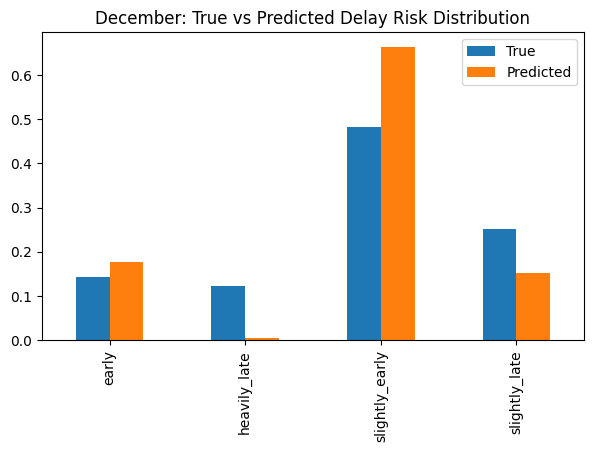

In [121]:
# True distribution (December)
true_dist = test["delay_bin"].value_counts(normalize=True).sort_index()

# Predicted distribution
pred_bins = pd.Series(y_pred_cls, index=test.index)
pred_dist = pred_bins.value_counts(normalize=True).sort_index()

# Combine
dist_df = pd.DataFrame({
    "True": true_dist,
    "Predicted": pred_dist
})

dist_df.plot(kind="bar", figsize=(7,4),
             title="December: True vs Predicted Delay Risk Distribution")


# Why Boosting (XGBoost) is a Natural Next Step

The Random Forest results revealed a systematic weakness:  
while normal delay situations are predicted reliably, rare and severe delays
(“heavily_late”) are strongly underestimated.

Boosting directly addresses this limitation. Unlike Random Forests, which build
many independent trees, boosting trains trees **sequentially**. Each new tree
focuses on the observations that were previously predicted poorly by increasing
their importance (reweighting the errors).

This makes boosting particularly suitable for our setting, where:
- extreme delays are rare but operationally critical,
- errors are not symmetric,
- and nonlinear interactions between weather, time, and station risk exist.

We therefore apply XGBoost as a final model to test whether focusing on hard
examples improves performance and the representation of severe delay risks.
The same evaluation plots as before are used to directly compare all models.


In [124]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb = XGBRegressor(
    n_estimators=400,        # kleiner, damit es schnell bleibt
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_int, y_train)

y_pred = xgb.predict(X_test_int)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\nDecember performance (XGBoost, no early stopping):")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.4f}")



December performance (XGBoost, no early stopping):
MAE  = 3.765
RMSE = 6.970
R2   = 0.4685


In [125]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [150, 300, 500],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9]
}

search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=8,                 # nur 8 Kombis
    scoring="neg_mean_absolute_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_xgb.fit(X_train_int, y_train)

print("Best XGB params:", search_xgb.best_params_)
print("Best CV MAE:", -search_xgb.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGB params: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
Best CV MAE: 3.7321936490056515


In [126]:
best_xgb = search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_int)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\nDecember performance (tuned XGBoost):")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R2   = {r2:.4f}")



December performance (tuned XGBoost):
MAE  = 3.766
RMSE = 6.980
R2   = 0.4669


Interestingly, hyperparameter tuning led to a improvement of around 3 percent R² for the
Random Forest model, while XGBoost showed almost identical performance before
and after optimization. This suggests that the predictive ceiling is primarily
driven by data and feature limitations rather than model capacity. Once this
limit is reached, more complex models cannot further reduce the irreducible
error.


In [128]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_cls = le.fit_transform(train_sub["delay_bin"])
y_test_cls  = le.transform(test["delay_bin"])

print("Class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


Class mapping: {'early': 0, 'heavily_late': 1, 'slightly_early': 2, 'slightly_late': 3}


In [ ]:
from xgboost import XGBClassifier

# falls du search_xgb hast (aus XGBRegressor tuning):
xgb_params = getattr(search_xgb, "best_params_", {})

# sichere defaults, falls xgb_params leer ist
base_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
)

# regression-tuned params überschreiben defaults
base_params.update(xgb_params)

xgb_clf = XGBClassifier(
    **base_params,
    objective="multi:softprob",
    num_class=len(le.classes_),
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_int, y_train_cls)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [130]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_xgb = xgb_clf.predict(X_test_int)

print("XGBoost accuracy:", accuracy_score(y_test_cls, y_pred_xgb))
print(classification_report(y_test_cls, y_pred_xgb, target_names=le.classes_))


XGBoost accuracy: 0.6178470069668642
                precision    recall  f1-score   support

         early       0.75      0.92      0.83    281594
  heavily_late       0.45      0.02      0.04    240005
slightly_early       0.61      0.88      0.72    942561
 slightly_late       0.48      0.25      0.32    492818

      accuracy                           0.62   1956978
     macro avg       0.57      0.51      0.48   1956978
  weighted avg       0.58      0.62      0.55   1956978



<Axes: title={'center': 'December: True vs RF vs XGBoost (Delay Risk Buckets)'}>

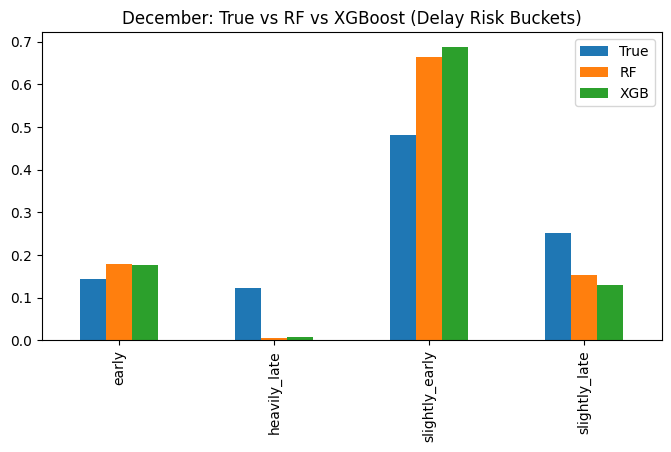

In [131]:
import pandas as pd

true_dist = test["delay_bin"].value_counts(normalize=True).sort_index()

rf_dist = pd.Series(y_pred_cls).value_counts(normalize=True).sort_index()

xgb_labels = le.inverse_transform(y_pred_xgb)
xgb_dist = pd.Series(xgb_labels).value_counts(normalize=True).sort_index()

dist_compare = pd.DataFrame({
    "True": true_dist,
    "RF": rf_dist,
    "XGB": xgb_dist
})

dist_compare.plot(kind="bar", figsize=(8,4),
                  title="December: True vs RF vs XGBoost (Delay Risk Buckets)")



To explicitly prioritize severe delays, we apply **cost-sensitive learning**
by assigning higher weights to underrepresented classes. In XGBoost, this is
implemented via `sample_weight`, increasing the penalty for misclassifying
rare delay categories. We expect overall accuracy to remain similar (or slightly
decrease), while recall for "heavily_late" should improve.

As an additional robustness formulation, we also consider a binary "severe delay"
classification (delay > 5 minutes), which is operationally meaningful and often
easier to learn.

In [132]:
import numpy as np

class_counts = np.bincount(y_train_cls)  # y_train_cls sind int labels
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
sample_weight = class_weights[y_train_cls]


In [133]:
from xgboost import XGBClassifier

best_params = getattr(search_xgb, "best_params_", {}).copy()

xgb_clf_w = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    num_class=len(le.classes_),
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_clf_w.fit(X_train_int, y_train_cls, sample_weight=sample_weight)
y_pred_xgb_w = xgb_clf_w.predict(X_test_int)


In [134]:
from sklearn.metrics import classification_report, accuracy_score

print("Weighted XGB accuracy:", accuracy_score(y_test_cls, y_pred_xgb_w))
print(classification_report(y_test_cls, y_pred_xgb_w, target_names=le.classes_))


Weighted XGB accuracy: 0.5456780812047963
                precision    recall  f1-score   support

         early       0.68      0.98      0.80    281594
  heavily_late       0.26      0.40      0.32    240005
slightly_early       0.74      0.49      0.59    942561
 slightly_late       0.41      0.47      0.44    492818

      accuracy                           0.55   1956978
     macro avg       0.52      0.58      0.54   1956978
  weighted avg       0.59      0.55      0.55   1956978



<Axes: title={'center': 'December Delay Risk Buckets: True vs RF vs XGB vs Weighted XGB'}>

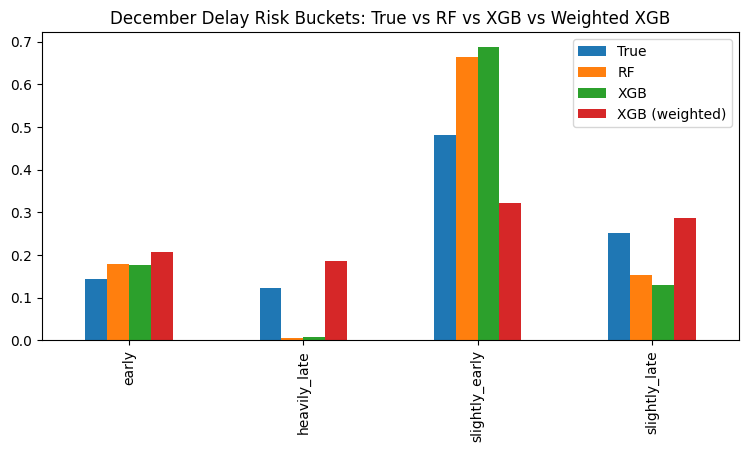

In [135]:


true_dist = test["delay_bin"].value_counts(normalize=True).sort_index()
rf_dist   = pd.Series(y_pred_cls).value_counts(normalize=True).sort_index()

xgb_dist  = pd.Series(le.inverse_transform(y_pred_xgb)).value_counts(normalize=True).sort_index()
xgbw_dist = pd.Series(le.inverse_transform(y_pred_xgb_w)).value_counts(normalize=True).sort_index()

dist_compare = pd.DataFrame({
    "True": true_dist,
    "RF": rf_dist,
    "XGB": xgb_dist,
    "XGB (weighted)": xgbw_dist
})

dist_compare.plot(kind="bar", figsize=(9,4),
                  title="December Delay Risk Buckets: True vs RF vs XGB vs Weighted XGB")


### Cost-Sensitive XGBoost: Trade-off Between Accuracy and Risk Detection

Introducing class weights shifts the learning objective from overall accuracy
towards detecting rare but operationally critical delay events. Compared to the
standard XGBoost classifier, the weighted model increases recall for the
“heavily_late” class from 2% to 40%, at the cost of a reduced overall accuracy
(62% → 55%).

This behavior is expected: the model now prioritizes severe delays and accepts
more false positives in the majority classes. While the unweighted model is
better calibrated for average performance, the weighted model is more suitable
for risk-sensitive applications, where missing a severe delay is more costly
than a false alarm.




## Key Insights from Task 2

1. Linear models explain the average behavior well but miss extremes.
2. Trees capture non-linear structure and improve predictive power.
3. Hyperparameter tuning is crucial for random forest models.
4. Predicting exact delays is inherently hard because extreme events are rare.
5. Reframing the task as **risk classification** reveals model limitations and
   practical trade-offs.
6. Cost-sensitive models can shift performance toward operationally critical
   events.


## Transition to Task 3

While Task 2 focused on predicting delay severity, **Task 3 moves fully into a
classification setting**, where the goal is not to predict delays, but to
identify **stations with high cancellation risk**.

The insights from Task 2 – especially class imbalance, cost sensitivity, and
tree-based models – directly motivate this next step.
